# Data analysis 2

## Adding some feature engineering

In [1]:
#Setting up environment
import pandas as pd
import os
import numpy as np
from IPython.display import Math

from statsmodels.stats.outliers_influence import variance_inflation_factor    
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import metrics, svm,tree,preprocessing
from pprint import pprint
from sklearn.metrics import (auc, confusion_matrix, roc_curve, accuracy_score, precision_score)
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Uploading data
df_processed= pd.read_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/processed/data_all_features.csv", index_col=[0])
df_processed.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_category
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Correlation matrix in Data exploration has shown that there is a lot of multilinearity in the data set. 
## Calculating the variance inflation factor 
https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python/

In [7]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

df_removing_features=calculate_vif_(df_processed)

dropping 'radius_mean' at index: 0
dropping 'radius_worst' at index: 19
dropping 'perimeter_mean' at index: 1
dropping 'perimeter_worst' at index: 19
dropping 'fractal_dimension_mean' at index: 7
dropping 'smoothness_worst' at index: 19
dropping 'texture_worst' at index: 17
dropping 'fractal_dimension_worst' at index: 22
dropping 'symmetry_worst' at index: 21
dropping 'concavity_mean' at index: 4
dropping 'radius_se' at index: 6
dropping 'concave points_worst' at index: 18
dropping 'smoothness_mean' at index: 2
dropping 'compactness_mean' at index: 2
dropping 'area_mean' at index: 1
dropping 'compactness_worst' at index: 13
dropping 'perimeter_se' at index: 4
dropping 'symmetry_mean' at index: 2
dropping 'texture_mean' at index: 0
dropping 'concave points_se' at index: 6
dropping 'compactness_se' at index: 4
dropping 'concave points_mean' at index: 0
dropping 'area_worst' at index: 6
dropping 'symmetry_se' at index: 4
dropping 'concavity_worst' at index: 5
dropping 'fractal_dimension_s

In [8]:
df_removing_features.to_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/processed/data_cleaned_features.csv")

In [15]:
#Correlation plot
corr = df_removing_features.corr()
corr.style.background_gradient(cmap='coolwarm')

,texture_se,area_se,concavity_se,diagnosis_category
texture_se,1,0.111567,0.194998,-0.00830333
area_se,0.111567,1,0.270895,0.548236
concavity_se,0.194998,0.270895,1,0.25373
diagnosis_category,-0.00830333,0.548236,0.25373,1


In [16]:
df_removing_features.columns

Index(['texture_se', 'area_se', 'concavity_se', 'diagnosis_category'], dtype='object')

## Run a simple decision tree on my new data set
### Load my train and test data first

In [21]:
X_test_df= pd.read_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/X_test.csv", index_col=[0])
X_test_df.columns=df_processed.columns[:-1]
X_test_df.head()
X_test = X_test_df[df_removing_features.columns[:-1]].values

In [22]:
X_train_df= pd.read_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/X_train.csv", index_col=[0])
X_train_df.columns=df_processed.columns[:-1]
X_train = X_train_df[df_removing_features.columns[:-1]].values

In [24]:
y_train_df = pd.read_csv('/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/y_train.csv', header=None, index_col=[0]);
y_train = y_train_df.iloc[:,0]
y_test_df = pd.read_csv('/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/y_test.csv', header=None, index_col=[0]);
y_test = y_test_df.iloc[:,0]

In [25]:
# Tune Decision Tree
num_leaves = [5, 10, 15, 20, 30, 40, 50]
depth = np.arange(3, 21)
num_samples_split = np.arange(10,20)
params_DT = {"max_depth": depth, "min_samples_leaf": num_leaves, "min_samples_split":num_samples_split}
random_state = 42
classifier_DT = DecisionTreeClassifier(random_state=random_state)
grid_DT = GridSearchCV(classifier_DT, params_DT,scoring='roc_auc');
grid_DT.fit(X_train,y_train)

prediction_DT = grid_DT.predict(X_test)
probability_DT = grid_DT.predict_proba(X_test)

In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, prediction_DT))

Accuracy: 0.8859649122807017


[Text(571.9499999999999, 498.3, 'texture_mean <= 31.285\nsamples = 100.0%\nvalue = [0.629, 0.371]'),
 Text(251.1, 407.70000000000005, 'texture_mean <= 18.515\nsamples = 64.2%\nvalue = [0.887, 0.113]'),
 Text(111.6, 317.1, 'texture_mean <= 13.935\nsamples = 26.8%\nvalue = [0.975, 0.025]'),
 Text(55.8, 226.5, 'samples = 12.7%\nvalue = [1.0, 0.0]'),
 Text(167.39999999999998, 226.5, 'texture_mean <= 17.03\nsamples = 14.1%\nvalue = [0.953, 0.047]'),
 Text(111.6, 135.89999999999998, 'samples = 7.7%\nvalue = [0.914, 0.086]'),
 Text(223.2, 135.89999999999998, 'samples = 6.4%\nvalue = [1.0, 0.0]'),
 Text(390.59999999999997, 317.1, 'perimeter_mean <= 0.013\nsamples = 37.4%\nvalue = [0.824, 0.176]'),
 Text(334.79999999999995, 226.5, 'samples = 8.1%\nvalue = [1.0, 0.0]'),
 Text(446.4, 226.5, 'radius_mean <= 1.022\nsamples = 29.2%\nvalue = [0.774, 0.226]'),
 Text(334.79999999999995, 135.89999999999998, 'radius_mean <= 0.821\nsamples = 12.3%\nvalue = [0.661, 0.339]'),
 Text(279.0, 45.299999999999955

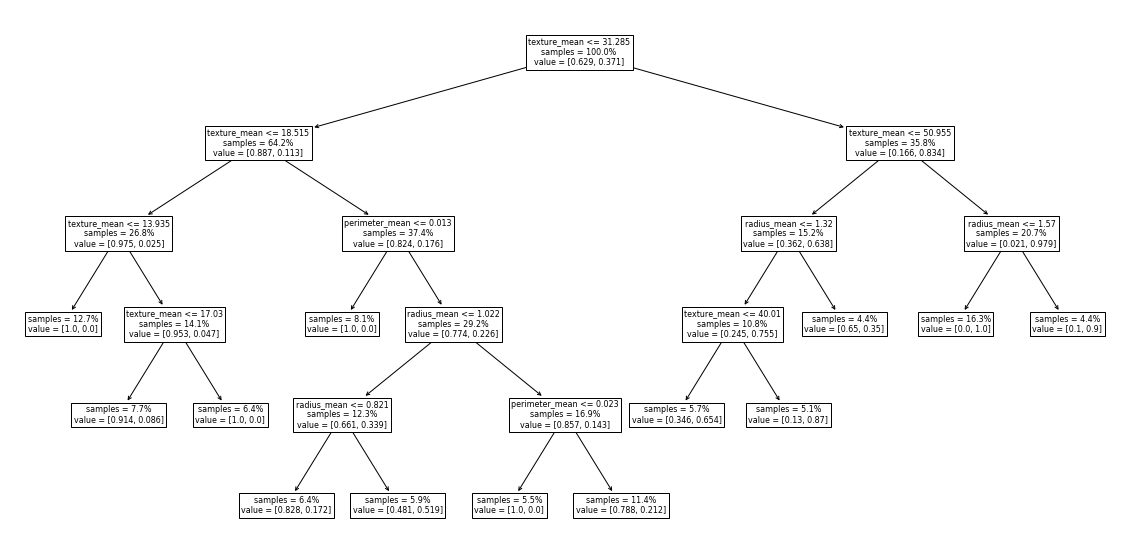

In [27]:
model_DT= grid_DT.best_estimator_
plt.figure(figsize=(20,10)) 
tree.plot_tree(model_DT, feature_names=df_processed.columns[0:-1], impurity=False, proportion=True)

In [28]:
print(metrics.confusion_matrix(y_test, prediction_DT))

[[64  7]
 [ 6 37]]


In [29]:
tree_tn, tree_fn, tree_fp, tree_tp = metrics.confusion_matrix(y_test, prediction_DT).ravel()
recall_DT= tree_tp/(tree_tp + tree_fn)
print(recall_DT)

0.8409090909090909


## Accuracy decreased from 95% to 92%, recall decreased from 93% to 90%
### Idea for more work: look at the change of recall and accuracy with the step-wise removal of features 

In [30]:
classifier_LR = LogisticRegression(n_jobs = -1)
classifier_LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
prediction_LR = classifier_LR.predict(X_test)
probability_LR = classifier_LR.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, prediction_LR))
print(metrics.confusion_matrix(y_test, prediction_LR))

Accuracy: 0.9210526315789473
[[67  4]
 [ 5 38]]


In [32]:
lr_tn, lr_fn, lr_fp, lr_tp = metrics.confusion_matrix(y_test, prediction_LR).ravel()
recall_LR = lr_tp/(lr_tp + lr_fn)
print(recall_LR)

0.9047619047619048


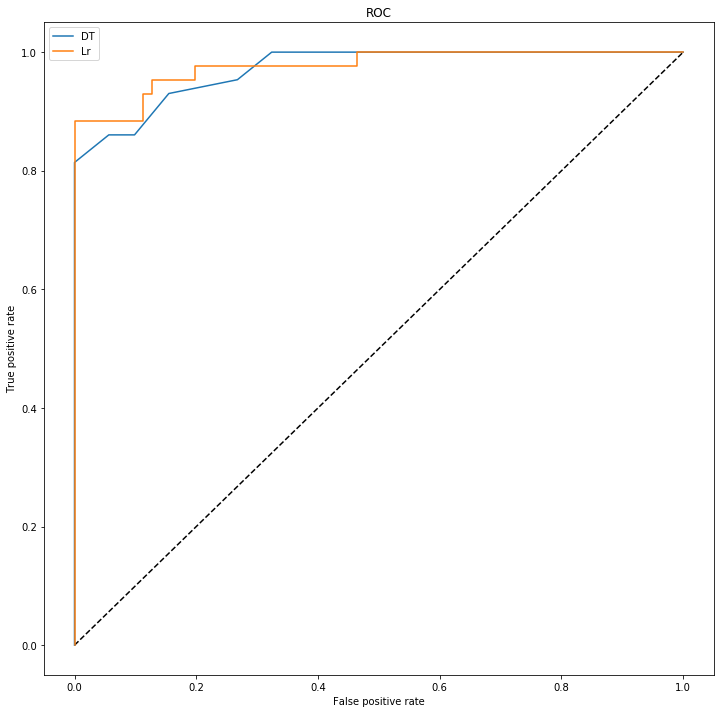

In [33]:
false_pos_rate_DT,true_pos_rate_DT, thresholds_DT = roc_curve(y_test, probability_DT[:, 1])
false_pos_rate_LR,true_pos_rate_LR, thresholds_LR = roc_curve(y_test, probability_LR[:, 1])

# Plot the ROC curve
fig = plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_rate_DT, true_pos_rate_DT, label='DT')
plt.plot(false_pos_rate_LR, true_pos_rate_LR, label='Lr')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='best')
plt.show()

In [34]:
metrics.auc(false_pos_rate_DT, true_pos_rate_DT)
metrics.auc(false_pos_rate_LR, true_pos_rate_LR)

0.9764166393711103